In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNetCV

In [2]:
data = pd.read_csv("/Users/jacobbills/Desktop/Economics/Twitter_sentiment_DJIA30/Combined_stocks.csv")

Let's make some percents for the different sentiment scores

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10130 entries, 0 to 10129
Data columns (total 48 columns):
Unnamed: 0    10130 non-null int64
AXP           10130 non-null int64
BA            10130 non-null int64
CAT           10130 non-null int64
CLOSE         10130 non-null float64
CSCO          10130 non-null int64
CVX           10130 non-null int64
DD            10130 non-null int64
DIS           10130 non-null int64
GE            10130 non-null int64
GS            10130 non-null int64
HD            10130 non-null int64
HIGH          10130 non-null float64
IBM           10130 non-null int64
INTC          10130 non-null int64
JNJ           10130 non-null int64
JPM           10130 non-null int64
KO            10130 non-null int64
LOW           10130 non-null float64
MCD           10130 non-null int64
MMM           10130 non-null int64
MRK           10130 non-null int64
MSFT          10130 non-null int64
NKE           10130 non-null int64
NUM_NEG       10130 non-null int64
NUM_NEG1  

In [6]:
data['NUM_NEG_PER'] = data['NUM_NEG']/data['TW']

In [10]:
sentiments = ['NUM_NEG', 'NUM_NEG1', 'NUM_NEG2','NUM_NEU','NUM_NEU1','NUM_NEU2','NUM_POS','NUM_POS1','NUM_POS2']
for e in sentiments:
    if e.endswith("1"):
        data[e+"_PER"] = data[e]/data['TW1']
    elif e.endswith("2"):
        data[e+"_PER"] = data[e]/data['TW2']
    else:
        data[e+"_PER"] = data[e]/data['TW']

In [14]:
target = data.CLOSE
high = data.HIGH
low = data.LOW

In [79]:
data1 = data.drop(columns=['CLOSE', 'HIGH', 'LOW', 'Unnamed: 0'])

In [80]:
data_dummies = pd.get_dummies(data1)

In [81]:
data_nodate = data1.drop(columns='Date')

In [94]:
data_prev = data_nodate.drop(columns=['NUM_NEG', 'NUM_NEU', 'NUM_POS', 'NUM_NEG_PER', 'NUM_NEU_PER', 'NUM_POS_PER'])

In [99]:
data_nopen = data_dummies.drop(columns='OPEN')
data_nopen_date = data_nodate.drop(columns='OPEN')
data_nopen_prev = data_prev.drop(columns='OPEN')

In [83]:
is_null = data_dummies.columns[data_dummies.isnull().any()]
is_null

Index(['NUM_NEG_PER', 'NUM_NEG1_PER', 'NUM_NEG2_PER', 'NUM_NEU_PER',
       'NUM_NEU1_PER', 'NUM_NEU2_PER', 'NUM_POS_PER', 'NUM_POS1_PER',
       'NUM_POS2_PER'],
      dtype='object')

In [84]:
data_dummies[is_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10130 entries, 0 to 10129
Data columns (total 9 columns):
NUM_NEG_PER     10129 non-null float64
NUM_NEG1_PER    10128 non-null float64
NUM_NEG2_PER    10128 non-null float64
NUM_NEU_PER     10129 non-null float64
NUM_NEU1_PER    10128 non-null float64
NUM_NEU2_PER    10128 non-null float64
NUM_POS_PER     10129 non-null float64
NUM_POS1_PER    10128 non-null float64
NUM_POS2_PER    10128 non-null float64
dtypes: float64(9)
memory usage: 712.3 KB


In [85]:
for e in is_null:
    data_dummies[e].fillna(data_dummies[e].mean(), inplace=True)
    data_nodate[e].fillna(data_nodate[e].mean(), inplace=True)
    data_prev[e].fillna(data_prev[e].mean(), inplace=True)

Now that the data is clean, we can try to run some different models on it

In [95]:
scaler = StandardScaler()
scaler.fit(data_dummies)
scaled_df = scaler.transform(data_dummies)

scaler.fit(data_nodate)
scaled_df_no = scaler.transform(data_nodate)

scaler.fit(data_prev)
scaled_prev = scaler.transform(data_prev)

/Users/jacobbills/Desktop/python/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jacobbills/Desktop/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jacobbills/Desktop/python/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jacobbills/Desktop/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [96]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=.2, random_state = 11)
X_train1, X_test1, y_train1, y_test1 = train_test_split(scaled_df_no, target, test_size=.2, random_state = 11)
X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_prev, target, test_size=.2, random_state = 11)

In [88]:
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Train MSE: 0.6949741316371656
Test MSE: 0.6221862168659308


In [61]:
## I took this from their website, why isn't this a normal thing you can import? 

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/jacobbills/Desktop/python/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

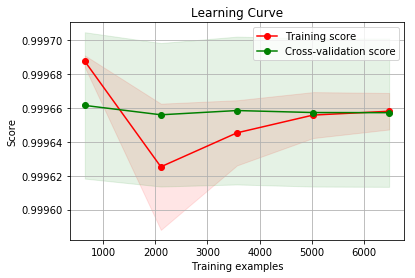

In [62]:
plot_learning_curve(clf, "Learning Curve", X_train, y_train, cv=5)

In [89]:
sorted(list(zip(data_dummies, clf.coef_)), key=lambda x: abs(x[1]))

[('AXP', -0.0),
 ('BA', 0.0),
 ('CAT', 0.0),
 ('CSCO', -0.0),
 ('CVX', 0.0),
 ('DD', -0.0),
 ('DIS', -0.0),
 ('GE', -0.0),
 ('GS', 0.0),
 ('HD', -0.0),
 ('IBM', 0.0),
 ('INTC', -0.0),
 ('JNJ', 0.0),
 ('JPM', -0.0),
 ('KO', -0.0),
 ('MCD', 0.0),
 ('MMM', 0.0),
 ('MRK', -0.0),
 ('MSFT', -0.0),
 ('NKE', -0.0),
 ('NUM_NEG', -0.0),
 ('NUM_NEG1', -0.0),
 ('NUM_NEG2', -0.0),
 ('NUM_NEU', -0.0),
 ('NUM_NEU1', -0.0),
 ('NUM_NEU2', -0.0),
 ('NUM_POS', 0.0),
 ('NUM_POS1', -0.0),
 ('NUM_POS2', 0.0),
 ('PFE', -0.0),
 ('PG', 0.0),
 ('T', -0.0),
 ('TRV', 0.0),
 ('TW', -0.0),
 ('TW1', -0.0),
 ('TW2', -0.0),
 ('UNH', 0.0),
 ('UTX', -0.0),
 ('V', 0.0),
 ('VZ', -0.0),
 ('WMT', 0.0),
 ('XOM', 0.0),
 ('NUM_NEG1_PER', 0.0),
 ('NUM_NEG2_PER', 0.0),
 ('NUM_NEU_PER', -0.0),
 ('NUM_NEU1_PER', 0.0),
 ('NUM_NEU2_PER', -0.0),
 ('NUM_POS_PER', 0.0),
 ('NUM_POS1_PER', -0.0),
 ('NUM_POS2_PER', 0.0),
 ('Date_1/10/14', -0.0),
 ('Date_1/13/14', -0.0),
 ('Date_1/14/14', 0.0),
 ('Date_1/15/14', 0.0),
 ('Date_1/16/14', -0.

In [90]:
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train1, y_train1)
train_predictions = clf.predict(X_train1)
test_predictions = clf.predict(X_test1)
print("Train MSE: {}".format(mean_squared_error(y_train1, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test1, test_predictions)))

Train MSE: 0.6949741262750946
Test MSE: 0.6221862114956936


In [91]:
sorted(list(zip(data_nodate, clf.coef_)), key=lambda x: abs(x[1]))

[('AXP', -0.0),
 ('BA', 0.0),
 ('CAT', 0.0),
 ('CSCO', -0.0),
 ('CVX', 0.0),
 ('DD', -0.0),
 ('DIS', -0.0),
 ('GE', -0.0),
 ('GS', 0.0),
 ('HD', -0.0),
 ('IBM', 0.0),
 ('INTC', -0.0),
 ('JNJ', 0.0),
 ('JPM', -0.0),
 ('KO', -0.0),
 ('MCD', 0.0),
 ('MMM', 0.0),
 ('MRK', -0.0),
 ('MSFT', -0.0),
 ('NKE', -0.0),
 ('NUM_NEG', -0.0),
 ('NUM_NEG1', -0.0),
 ('NUM_NEG2', -0.0),
 ('NUM_NEU', -0.0),
 ('NUM_NEU1', -0.0),
 ('NUM_NEU2', -0.0),
 ('NUM_POS', 0.0),
 ('NUM_POS1', -0.0),
 ('NUM_POS2', 0.0),
 ('PFE', -0.0),
 ('PG', 0.0),
 ('T', -0.0),
 ('TRV', 0.0),
 ('TW', -0.0),
 ('TW1', -0.0),
 ('TW2', -0.0),
 ('UNH', 0.0),
 ('UTX', -0.0),
 ('V', 0.0),
 ('VZ', -0.0),
 ('WMT', 0.0),
 ('XOM', 0.0),
 ('NUM_NEG1_PER', 0.0),
 ('NUM_NEG2_PER', 0.0),
 ('NUM_NEU_PER', -0.0),
 ('NUM_NEU1_PER', 0.0),
 ('NUM_NEU2_PER', -0.0),
 ('NUM_POS_PER', 0.0),
 ('NUM_POS1_PER', -0.0),
 ('NUM_POS2_PER', 0.0),
 ('NUM_NEG_PER', -0.013517965647263215),
 ('OPEN', 45.01774461071161)]

In [97]:
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train2, y_train2)
train_predictions = clf.predict(X_train2)
test_predictions = clf.predict(X_test2)
print("Train MSE: {}".format(mean_squared_error(y_train2, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test2, test_predictions)))

Train MSE: 0.6980498349467301
Test MSE: 0.6255164217586322


In [98]:
sorted(list(zip(data_prev, clf.coef_)), key=lambda x: abs(x[1]))

[('AXP', -0.0),
 ('BA', 0.0),
 ('CAT', 0.0),
 ('CSCO', -0.0),
 ('CVX', 0.0),
 ('DD', -0.0),
 ('DIS', -0.0),
 ('GE', -0.0),
 ('GS', 0.0),
 ('HD', -0.0),
 ('IBM', 0.0),
 ('INTC', -0.0),
 ('JNJ', 0.0),
 ('JPM', -0.0),
 ('KO', -0.0),
 ('MCD', 0.0),
 ('MMM', 0.0),
 ('MRK', -0.0),
 ('MSFT', -0.0),
 ('NKE', -0.0),
 ('NUM_NEG1', -0.0),
 ('NUM_NEG2', -0.0),
 ('NUM_NEU1', -0.0),
 ('NUM_NEU2', -0.0),
 ('NUM_POS1', -0.0),
 ('NUM_POS2', 0.0),
 ('PFE', -0.0),
 ('PG', 0.0),
 ('T', -0.0),
 ('TRV', 0.0),
 ('TW', -0.0),
 ('TW1', -0.0),
 ('TW2', -0.0),
 ('UNH', 0.0),
 ('UTX', -0.0),
 ('V', 0.0),
 ('VZ', -0.0),
 ('WMT', 0.0),
 ('XOM', 0.0),
 ('NUM_NEG1_PER', -0.0),
 ('NUM_NEG2_PER', 0.0),
 ('NUM_NEU1_PER', 0.0),
 ('NUM_NEU2_PER', -0.0),
 ('NUM_POS1_PER', -0.0),
 ('NUM_POS2_PER', 0.0),
 ('OPEN', 45.01678246941146)]

In [100]:
scaler = StandardScaler()
scaler.fit(data_nopen)
scaled_df = scaler.transform(data_nopen)

scaler.fit(data_nopen_date)
scaled_df_no = scaler.transform(data_nopen_date)

scaler.fit(data_nopen_prev)
scaled_prev = scaler.transform(data_nopen_prev)

/Users/jacobbills/Desktop/python/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jacobbills/Desktop/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jacobbills/Desktop/python/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jacobbills/Desktop/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [101]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(scaled_df, target, test_size=.2, random_state = 11)
X_train4, X_test4, y_train4, y_test4 = train_test_split(scaled_df_no, target, test_size=.2, random_state = 11)
X_train5, X_test5, y_train5, y_test5 = train_test_split(scaled_prev, target, test_size=.2, random_state = 11)

In [102]:
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train3, y_train3)
train_predictions = clf.predict(X_train3)
test_predictions = clf.predict(X_test3)
print("Train MSE: {}".format(mean_squared_error(y_train3, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test3, test_predictions)))
print(sorted(list(zip(data_nopen, clf.coef_)), key=lambda x: abs(x[1])))

Train MSE: 25.774255347942862
Test MSE: 29.288411766336193
[('HD', -0.0), ('NUM_NEG', -0.0), ('NUM_NEG1', -0.0), ('NUM_NEG2', -0.0), ('NUM_NEU', -0.0), ('NUM_NEU1', -0.0), ('NUM_NEU2', -0.0), ('NUM_POS', 0.0), ('NUM_POS1', 0.0), ('PG', 0.0), ('TW', -0.0), ('TW1', -0.0), ('TW2', -0.0), ('NUM_POS_PER', -0.0), ('NUM_POS1_PER', -0.0), ('NUM_POS2_PER', -0.0), ('Date_1/13/14', 0.0), ('Date_1/14/14', 0.0), ('Date_1/15/14', 0.0), ('Date_1/16/14', 0.0), ('Date_1/2/14', 0.0), ('Date_1/21/14', -0.0), ('Date_1/23/14', 0.0), ('Date_1/27/14', -0.0), ('Date_1/28/14', -0.0), ('Date_1/30/14', -0.0), ('Date_1/6/14', 0.0), ('Date_1/9/14', 0.0), ('Date_11/12/13', -0.0), ('Date_11/14/13', -0.0), ('Date_11/15/13', -0.0), ('Date_11/18/13', -0.0), ('Date_11/19/13', -0.0), ('Date_11/21/13', -0.0), ('Date_11/22/13', -0.0), ('Date_11/25/13', -0.0), ('Date_11/26/13', -0.0), ('Date_11/27/13', 0.0), ('Date_11/29/13', -0.0), ('Date_12/10/13', -0.0), ('Date_12/16/13', -0.0), ('Date_12/17/13', -0.0), ('Date_12/18/13',

In [103]:
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train4, y_train4)
train_predictions = clf.predict(X_train4)
test_predictions = clf.predict(X_test4)
print("Train MSE: {}".format(mean_squared_error(y_train4, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test4, test_predictions)))
print(sorted(list(zip(data_nopen_date, clf.coef_)), key=lambda x: abs(x[1])))

Train MSE: 36.04895309315978
Test MSE: 37.75881021970031
[('HD', 0.0), ('NUM_NEG', 0.0), ('NUM_NEG1', -0.0), ('NUM_NEG2', 0.0), ('NUM_NEU', 0.0), ('NUM_NEU1', 0.0), ('NUM_NEU2', 0.0), ('PG', 0.0), ('TW', 0.0), ('TW1', 0.0), ('NUM_POS_PER', -0.0), ('NUM_POS1_PER', -0.0), ('NUM_POS2_PER', -0.0), ('TW2', 0.05928799895857067), ('NUM_NEG1_PER', -0.09941212970419128), ('NUM_NEG_PER', -0.17456672900308312), ('NUM_POS2', 0.21430939211982022), ('NUM_NEG2_PER', -0.24735483028365648), ('NUM_POS', 0.24840842011094325), ('NUM_POS1', 0.26831254578191754), ('NUM_NEU2_PER', 0.40581874258592765), ('WMT', -0.47038460825169287), ('UNH', -0.5481074251972642), ('NUM_NEU1_PER', 0.5980185240579937), ('NUM_NEU_PER', 0.6218523869509252), ('DIS', -0.7275648719227753), ('NKE', -0.8268819055477785), ('TRV', 1.2630030381981432), ('AXP', 1.2697037340366724), ('JNJ', 2.6191465772563918), ('CAT', 2.7604477825730642), ('XOM', 2.765542963541569), ('DD', -2.877323765492274), ('MCD', 3.1153773077761144), ('JPM', -3.91460

In [104]:
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train5, y_train5)
train_predictions = clf.predict(X_train5)
test_predictions = clf.predict(X_test5)
print("Train MSE: {}".format(mean_squared_error(y_train5, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test5, test_predictions)))
print(sorted(list(zip(data_nopen_prev, clf.coef_)), key=lambda x: abs(x[1])))

Train MSE: 36.59852877098403
Test MSE: 38.092109124876266
[('HD', 0.0), ('NUM_NEG1', -0.0), ('NUM_NEG2', 0.0), ('NUM_NEU1', 0.0), ('NUM_NEU2', 0.0), ('PG', 0.0), ('TW1', 0.0), ('NUM_POS1_PER', -0.0), ('NUM_POS2_PER', -0.0), ('TW2', 0.08999069270163308), ('TW', 0.09539467593899864), ('NUM_NEG1_PER', -0.15752208002475032), ('NUM_POS2', 0.22409680767781998), ('NUM_NEG2_PER', -0.27207238482315504), ('NUM_POS1', 0.291687966409637), ('NUM_NEU2_PER', 0.4771318477333087), ('WMT', -0.48524966799481506), ('UNH', -0.566674741901884), ('DIS', -0.7158761308126995), ('NUM_NEU1_PER', 0.7471552682550409), ('NKE', -0.8532421474821428), ('AXP', 1.2617061765294721), ('TRV', 1.271109468133744), ('JNJ', 2.620561748189393), ('CAT', 2.722703935244513), ('XOM', 2.753877221677106), ('DD', -2.8615805625034123), ('MCD', 3.106924117460492), ('JPM', -3.961016462175507), ('MRK', -4.754415122370314), ('UTX', 5.303196411895585), ('VZ', -5.351105259469495), ('KO', -6.887693912806744), ('MSFT', -7.414372117701034), ('C